In [1]:
import networkx as nx
import copy
from edgelabelgraph import EdgeLabelGraph

In [2]:
from collections import Counter
from bintrees import RBTree

def greedy_find_dense_label_induced_subgraph(graph, conjunction=True, return_graph=False):
    G = graph.create_copy()
    
    r_v_k = dict()
    m_k = Counter()
    n_k = Counter()

    for edge in G.edges:
        for label in G.edge_labels[edge]:
            m_k[label] += 1
            for vertex in edge:
                if not vertex in r_v_k:
                    r_v_k[vertex] = Counter()
                r_v_k[vertex][label] += 1

    for vertex in r_v_k:
        for label in r_v_k[vertex]:
            n_k[label] += 1
    
    
    L = []
    L_set = set()
    best_L = []
    best_density = -1
    best_G = None
    if not conjunction and return_graph:
        G2 = EdgeLabelGraph()
    
    if conjunction:
        T = RBTree()
        label_densities = dict()
        for label in G.all_labels:
            if n_k[label] == 0:
                density = 0
            else:
                density = m_k[label] / n_k[label]
            label_densities[label] = density
            T.insert((density, label), None)
    else:
        n = 0
        m = 0
        r_v = dict()
        for edge in G.edges:
            for v in edge:
                r_v[v] = 0

    while len(G.all_labels) > len(L) and (not conjunction or len(T) > 0):
        if conjunction:
            density, k = T.pop_max()[0]
        else:
            best_k_density = -1
            best_k = None
            for k in G.all_labels:
                if k in L_set:
                    continue
                if n == 0 and n_k[k] == 0:
                    density = 0
                else:
                    density = (m + m_k[k])/(n + n_k[k])
                if density > best_k_density:
                    best_k_density = density
                    best_k = k
            density, k = best_k_density, best_k
        L.append(k)
        L_set.add(k)
        updated_labels = []
        for edge in tuple(G.edges):
            u, v = edge
            if conjunction:
                if k in G.edge_labels[edge]:
                    continue
                for l in tuple(G.edge_labels[edge]):
                    if l in L_set:
                        continue
                    m_k[l] -= 1
                    r_v_k[v][l] -= 1
                    r_v_k[u][l] -= 1
                    if r_v_k[v][l] == 0:
                        n_k[l] -= 1
                    if r_v_k[u][l] == 0:
                        n_k[l] -= 1
                    updated_labels.append(l)
            else:
                if k not in G.edge_labels[edge]:
                    continue
                for l in tuple(G.edge_labels[edge]):
                    if l in L_set:
                        continue
                    m_k[l] -= 1
                m += 1
                if r_v[v] == 0:
                    for l in r_v_k[v]:
                        n_k[l] -= 1
                    n += 1
                if r_v[u] == 0:
                    for l in r_v_k[u]:
                        n_k[l] -= 1
                    n += 1
                r_v[v] = 1
                r_v[u] = 1
            if not conjunction and return_graph:
                G2.add_edge_with_labels(edge, G.edge_labels[edge])
            G.delete_edge(edge)

        for l in updated_labels:
            T.pop((label_densities[l], l))
            if n_k[l] == 0:
                new_density = 0
            else:
                new_density = m_k[l] / n_k[l]
            T.insert((new_density, l), None)
            label_densities[l] = new_density

        if density > best_density:
            best_L = L.copy()
            best_density = density
            if return_graph:
                if conjunction:
                    best_G = G.create_copy()
                else:
                    best_G = G2.create_copy()
        
    if return_graph:
        return (best_density, best_L, best_G)
    return (best_density, best_L)

In [3]:
from datetime import datetime

def repeated_find_label_subgraph(graph, conjunction=True, max_iterations=5, track_time=False):
    results = []
    current_graph = graph.create_copy()
    i = 1
    while (i <= max_iterations or max_iterations <= 0) and current_graph.number_of_edges() > 0:
        if track_time:
            start_time = datetime.now()
        density, labels, return_graph = greedy_find_dense_label_induced_subgraph(
            current_graph, conjunction=conjunction, return_graph=True)
        print(density, labels, return_graph.number_of_nodes(), return_graph.number_of_edges())
        if track_time:
            print(datetime.now()-start_time)
        results.append((density, labels, return_graph.create_copy()))
        for edge in return_graph.edges:
            current_graph.delete_edge(edge)
        if not conjunction:
            current_graph.all_labels -= set(labels)
        i += 1
    return results

In [4]:
import numpy as np
np.random.seed(123)
n_vertices = 200
n_labels = 50
vertices = np.arange(n_vertices)
labels = np.arange(n_labels)

n_target_labels = 5
n_cliques = n_target_labels+1
n_clique_vertices_list = [10]*n_target_labels + [20]

epsilons = np.arange(0,0.5,0.05)

target_densities = np.array([])
greedy_densities = np.array([])

for epsilon in epsilons:
    p_add_clique_edge = 1.0-epsilon
    p_add_other_edge = 0+epsilon
    p_add_label = 0+epsilon

    G = EdgeLabelGraph()

    target_labels = list(sorted(np.random.choice(labels, size=n_target_labels, replace=False)))
    target_labels_set = set(target_labels)
    other_labels = set(labels)-set(target_labels)
    n_target_edges = 0
    target_vertices = set()

    vertex_indx = 0
    for clique_indx in range(n_cliques):
        n_clique_vertices = n_clique_vertices_list[clique_indx]
        clique_labels = set(target_labels[:clique_indx] + target_labels[clique_indx+1:])

        for u in range(vertex_indx, vertex_indx + n_clique_vertices - 1):
            for v in range(u+1, vertex_indx + n_clique_vertices):
                if np.random.random() <= p_add_clique_edge: 
                    edge_labels = clique_labels.copy()
                    for label in other_labels:
                        if np.random.random() <= p_add_label: 
                            edge_labels.add(label)
                    G.add_edge_with_labels((u,v), edge_labels)
                    if target_labels_set.issubset(edge_labels):
                        n_target_edges += 1
                        target_vertices.add(u)
                        target_vertices.add(v)


                
        for u in range(vertex_indx, vertex_indx + n_clique_vertices):
            for v in range(vertex_indx + n_clique_vertices, n_vertices):
                if np.random.random() <= p_add_other_edge: 
                    edge_labels = set()
                    for label in labels:
                        if np.random.random() <= p_add_label: 
                            edge_labels.add(label)
                    G.add_edge_with_labels((u,v), edge_labels)
                    if target_labels_set.issubset(edge_labels):
                        n_target_edges += 1
                        target_vertices.add(u)
                        target_vertices.add(v)

        vertex_indx += n_clique_vertices

    n_target_clique_vertices = n_clique_vertices_list[-1]

    target_density = n_target_edges/len(target_vertices)
    greedy_density, greedy_labels = greedy_find_dense_label_induced_subgraph(G, conjunction=True)
    target_densities = np.append(target_densities, target_density)
    greedy_densities = np.append(greedy_densities, greedy_density)
    print("{:.2f}".format(epsilon), "{:.2f}".format(target_density), "{:.2f}".format(greedy_density), target_labels, sorted(greedy_labels))

0.00 9.50 9.50 [10, 13, 18, 30, 46] [10, 13, 18, 30, 46]
0.05 9.05 9.05 [17, 21, 27, 38, 46] [17, 21, 27, 38, 46]
0.10 8.55 8.55 [0, 5, 27, 30, 43] [0, 5, 27, 30, 43]
0.15 8.20 8.20 [24, 30, 33, 35, 44] [24, 30, 33, 35, 44]
0.20 7.05 7.05 [5, 8, 10, 24, 40] [5, 8, 10, 24, 40]
0.25 5.68 5.68 [6, 14, 21, 26, 34] [6, 14, 21, 26, 34]
0.30 4.75 6.43 [2, 5, 7, 22, 28] [28]
0.35 2.86 8.04 [13, 16, 22, 32, 40] [40]
0.40 2.01 10.41 [12, 27, 37, 44, 49] [12]
0.45 1.72 12.62 [1, 14, 26, 33, 35] [1]


In [5]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib

def plot_synthetic_density(epsilons, target_densities, greedy_densities, figname):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(4, 3)
    plt.plot(epsilons, target_densities, label="Target density", linewidth=3)
    plt.plot(epsilons, greedy_densities, label="Greedy density", linewidth=3)
    plt.legend()
    plt.xlabel("Random noise ε")
    plt.ylabel("Density")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
    plt.tight_layout()
    plt.savefig(figname, dpi=100, pad_inches=0)
    plt.show()

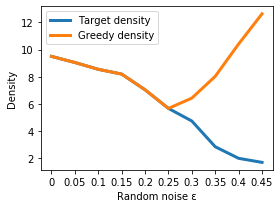

In [6]:
plot_synthetic_density(epsilons, target_densities, greedy_densities, "synthetic_density_conjunction.pdf")

In [7]:
import numpy as np
np.random.seed(123)
n_vertices = 200
n_labels = 50
vertices = np.arange(n_vertices)
labels = np.arange(n_labels)

n_target_labels = 5
n_clique_vertices = 40
n_clique_edges = n_clique_vertices * (n_clique_vertices - 1)/2


epsilons = np.arange(0,0.5,0.05)

target_densities = np.array([])
greedy_densities = np.array([])

for epsilon in epsilons:
    p_add_clique_edge = 1.0-epsilon
    p_add_other_edge = 0+epsilon
    p_add_label = 0+epsilon

    n_target_label_edges = np.zeros(n_target_labels)

    G = EdgeLabelGraph()

    target_labels = list(sorted(np.random.choice(labels, size=n_target_labels, replace=False)))
    target_labels_set = set(target_labels)
    other_labels = set(labels)-set(target_labels)
    n_target_edges = 0
    target_vertices = set()

    for u in range(n_clique_vertices-1):
        for v in range(u+1, n_clique_vertices):
            target_label_idx = np.random.choice(np.where(n_target_label_edges <= n_clique_edges/n_target_labels)[0])
            n_target_label_edges[target_label_idx] += 1
            
            if np.random.random() <= p_add_clique_edge: 
                n_target_edges += 1
                target_vertices.add(u)
                target_vertices.add(v)
                edge_labels = set({target_labels[target_label_idx]})

                for label in other_labels:
                    if np.random.random() <= p_add_label: 
                        edge_labels.add(label)
                G.add_edge_with_labels((u,v), edge_labels)
        
        for v in range(n_clique_vertices, n_vertices):
            if np.random.random() <= p_add_other_edge: 
                edge_labels = set()
                for label in other_labels:
                    if np.random.random() <= p_add_label: 
                        edge_labels.add(label)
                G.add_edge_with_labels((u,v), edge_labels)

    target_density = n_target_edges/len(target_vertices)
    greedy_density, greedy_labels = greedy_find_dense_label_induced_subgraph(G, conjunction=False)
    target_densities = np.append(target_densities, target_density)
    greedy_densities = np.append(greedy_densities, greedy_density)
    print("{:.2f}".format(epsilon), "{:.2f}".format(target_density), "{:.2f}".format(greedy_density), target_labels, sorted(greedy_labels))

0.00 19.50 19.50 [10, 13, 18, 30, 46] [10, 13, 18, 30, 46]
0.05 18.48 18.48 [15, 24, 31, 37, 43] [15, 24, 31, 37, 43]
0.10 17.60 17.60 [2, 9, 10, 30, 44] [2, 9, 10, 30, 44]
0.15 16.12 16.12 [6, 13, 25, 29, 44] [6, 13, 25, 29, 44]
0.20 15.10 15.10 [8, 19, 36, 40, 43] [8, 19, 36, 40, 43]
0.25 14.72 14.72 [2, 25, 31, 39, 43] [2, 25, 31, 39, 43]
0.30 13.22 12.20 [10, 18, 43, 45, 47] [1, 2, 3, 6, 8, 13, 16, 17, 20, 24, 26, 30, 31, 41, 46]
0.35 13.22 13.28 [10, 13, 17, 33, 41] [1, 4, 6, 8, 12, 18, 21, 34, 36, 39, 42, 45, 48, 49]
0.40 11.22 14.95 [8, 20, 26, 41, 49] [2, 5, 18, 19, 21, 24, 35, 40, 47, 48]
0.45 10.62 16.07 [2, 12, 21, 40, 47] [0, 1, 3, 8, 9, 10, 16, 23, 24, 25]


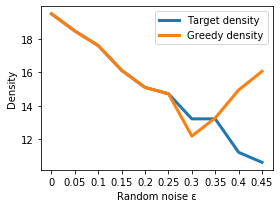

In [8]:
plot_synthetic_density(epsilons, target_densities, greedy_densities, "synthetic_density_disjunction.pdf")

In [ ]:
def remove_sparse_labels(graph, min_edges_proportion = 0.005):
    label_edge_counts = dict()
    for edge in graph.edges:
        for label in graph.edge_labels[edge]:
            if not label in label_edge_counts:
                label_edge_counts[label] = 0
            label_edge_counts[label] += 1
    removed_labels = set()
    for label in label_edge_counts:
        if label_edge_counts[label] < min_edges_proportion*graph.number_of_edges():
            removed_labels.add(label)
    for edge in tuple(graph.edges):
        graph.edge_labels[edge] -= removed_labels
        if len(graph.edge_labels[edge]) == 0:
            graph.delete_edge(edge)
    graph.all_labels -= removed_labels
    return label_edge_counts

In [ ]:
def run_decompostion(test_graph):
    vertex_to_index = dict([(v, i) for i, v in enumerate(test_graph.nodes)])
    with open("test_graph.txt", "w+") as f:
        for edge in test_graph.edges:
            f.write(f"{vertex_to_index[edge[0]]} {vertex_to_index[edge[1]]}\n")

    decomposition_path="../density-friendly-decomposition-master/decomposition/core"
    input_file="test_graph.txt"
    decomposition = !$decomposition_path -i $input_file -m e | head -n 1
    density, n_nodes = decomposition[0].split(" ")[:2]
    return density, n_nodes

In [ ]:
import pickle
datasets = [
    ("Enron", "enron_graph_subject_only.pkl", True),
    ("HEP-TH", "phys_graph_title_min_91_shared_2.pkl", False),
    ("DBLP", "dblp_graph_title_min_140_shared_2.pkl", False),
    ("Twitter", "tweets_graph.pkl", True),
]

with open("graph_results.csv", "w+") as results_file:
    results_file.write("dataset,n,m,L,p,density,t-con,n-con,m-con,density-con,L-con,"+\
                       "t-dis,n-dis,m-dis,density-dis,L-dis,"+\
                       "density-decomp,n-decomp\n")
    for title, graph_file, sparse_labels_removal in datasets:
        print(title)
        with open(graph_file, "rb") as file:
            test_graph = pickle.load(file)
        if sparse_labels_removal:
            min_edges_proportion = 0.001
            label_edge_counts = remove_sparse_labels(test_graph, min_edges_proportion=min_edges_proportion)
        else:
            test_graph.update_label_set()
        results = []
        for conjunction in [True, False]:
            t = datetime.now()
            density, labels, return_graph = greedy_find_dense_label_induced_subgraph(
                test_graph, conjunction=conjunction, return_graph=True)
            results.append(datetime.now()-t)
            results.append(return_graph.number_of_nodes())
            results.append(return_graph.number_of_edges())
            results.append(density)
            results.append(len(labels))
        results = [str(r) for r in results]
        decomp_density, decomp_nodes = run_decompostion(test_graph)
        n = test_graph.number_of_nodes()
        m = test_graph.number_of_edges()
        L = len(test_graph.all_labels)
        p = 0
        for edge in test_graph.edges:
            p += len(test_graph.edge_labels[edge])
        density = test_graph.density()
        results_file.write(f"\\dtname{{{title}}},{n},{m},{L},{p},{density},"+\
                            f"{','.join(results)},{decomp_density},{decomp_nodes}\n")
        

In [ ]:
import pickle

#with open("enron_graph_subject_only.pkl", "rb") as file:
#with open("phys_graph_title_min_91_shared_2.pkl", "rb") as file:
with open("tweets_graph.pkl", "rb") as file:
#with open("dblp_graph_title_min_140_shared_2.pkl", "rb") as file:
    test_graph = pickle.load(file)
    
sparse_labels_removal = True
if sparse_labels_removal:
    print(f"Labels before removal: {len(test_graph.all_labels)}")
    min_edges_proportion = 0.001
    print(f"Remove labels that occur in less than {int(min_edges_proportion*test_graph.number_of_edges())} edges")
    label_edge_counts = remove_sparse_labels(test_graph, min_edges_proportion=min_edges_proportion)
    
print(f"Nodes: {test_graph.number_of_nodes()}")
print(f"Edges: {test_graph.number_of_edges()}")
print(f"Labels: {len(test_graph.all_labels)}")
print(f"Density: {test_graph.density()}")
if not sparse_labels_removal:
    test_graph.update_label_set()

In [ ]:
density, n_nodes = run_decompostion(test_graph)
print(density, n_nodes)

In [111]:
# enron
results = repeated_find_label_subgraph(test_graph, conjunction=True)
print("------")
results = repeated_find_label_subgraph(test_graph, conjunction=False)

1.7222222222222223 ['mopa', 'action'] 18 31
1.5887265135699373 ['legal'] 479 761
1.7714285714285714 ['ecommerc', 'origin'] 35 62
1.5480769230769231 ['gi', 'updat'] 208 322
1.8333333333333333 ['meet', 'instruct', 'ga'] 12 22
------
2.1987023519870235 ['mopa', 'legal', 'gi', 'stanley', 'paraleg', 'raptor', 'pope', 'collater', 'ucc', 'scientist', 'org', 'ecommerc', 'bruce', 'emmis', 'alberta', 'plastic', 'pastoria', 'puls', 'japan', 'seat', 'gastech', 'block', 'setoff', 'england', 'wharton', 'bermuda', 'toll', 'entergi', 'usec', 'transammonia', 'tarantula', 'morton', 'rbc', 'singapor', 'demonstr', 'securit', 'ongo', 'cmua', 'currenc', 'staf', 'clerk', 'monterrey', 'clarksdal', 'ormet', 'distil', 'gambl', 'powel', 'westlaw', 'tibco', 'banqu', 'lover', 'japanes', 'mahonia', 'ibj', 'movement', 'mitsubishi', 'transmitt', 'dte', 'calm', 'metroga', 'offlin', 'imperi', 'asian', 'carol', 'ecp', 'omnibu', 'carr', 'balhorn', 'diamond', 'spinnak', 'plc', 'samuel', 'lunchabl', 'mne', 'amount', 'damir

1.1791823112223614 ['gir', 'accord', 'eix', 'timet', 'noon', 'sfo', 'blame', 'examin', 'fellow', 'lower', 'misdirect', 'ladwp', 'angelid', 'rais', 'editori', 'sac', 'bee', 'wit', 'elimin', 'coastal', 'pcg', 'voluntari', 'tra', 'figur', 'utilit', 'secretari', 'newsmak', 'montali', 'face', 'challeng', 'brult', 'pst', 'ami', 'refund', 'dereg', 'abx', 'declar', 'northern', 'cesg', 'principl', 'later', 'let', 'lawmak', 'soft', 'consequ', 'calif', 'alpert', 'walter', 'harvey', 'other', 'input', 'exam', 'florio', 'arm', 'sdge', 'hogan', 'deregul', 'expertfind', 'chief', 'gop', 'deliv', 'delay', 'ldc', 'legislatur', 'notebook', 'socalga', 'disclos', 'taster', 'merg', 'inquiri', 'type', 'titan', 'clair', 'purpos', 'acknowledg', 'mount', 'king', 'rebutt', 'specif', 'hunger', 'fountain', 'pegasu', 'peac', 'hace', 'iroquoi', 'psco', 'cut', 'turbopark', 'sec', 'teleconfer', 'mcneali', 'northwestern', 'checklist', 'testimoni', 'delta', 'coalit', 'cheney', 'wagner', 'kinder', 'pwr', 'food', 'sbx', 'd

1.0 ['mckinsey', 'cuiaba', 'siemen', 'eca', 'miracl', 'globe', 'biggest', 'rubi', 'compet', 'barney', 'websit', 'global', 'sher', 'manifesto', 'assumpt', 'repo', 'kaiser', 'kc', 'eweb', 'annex', 'hawaii', 'arthur', 'utilicorp', 'sara', 'must', 'morgan', 'bond', 'hill', 'transmiss', 'commission', 'bit', 'brief', 'length', 'sooo', 'mdea', 'cec', 'negoti', 'michael', 'respons', 'exhibit', 'consent', 'loi', 'spa', 'vepco', 'pass', 'counti', 'suiza', 'given', 'edgecomb', 'evil', 'lilco', 'advic', 'rev', 'elizabethtown', 'etown', 'ad', 'salsa', 'till', 'britney', 'swing', 'bomb', 'alp', 'develop', 'discuss', 'stanford', 'vinc', 'submitt', 'outlin', 'togeth', 'mgmt', 'recent', 'comparison', 'plant', 'mathemat', 'user', 'speak', 'rice', 'gourmet', 'lehman', 'altra', 'room', 'full', 'jame', 'luck', 'copi', 'brother', 'church', 'distribut', 'protocol', 'journal', 'initi', 'signatur', 'play', 'deer', 'cellular', 'cgey', 'grandma', 'student', 'voic', 'shoe', 'buddi', 'find', 'modif', 'hand', 'mess

In [101]:
# phys
results = repeated_find_label_subgraph(test_graph, conjunction=True)
print("------")
results = repeated_find_label_subgraph(test_graph, conjunction=False)

2.0 ['brane', 'theori', 'covari', 'super'] 7 14
1.3715083798882681 ['brane'] 1074 1473
2.5 ['theori', 'casimir', 'light'] 6 15
2.0 ['theori', 'mill', 'condens', 'nonlinear'] 5 10
2.0 ['theori', 'super', 'mechan', 'three'] 5 10
------
1.7015834348355663 ['brane', 'string', 'supergrav', 'super', 'supersymmetri', 'supersymmetr', 'noncommut', 'yau', 'superstr', 'bp', 'self', 'brst', 'instanton', 'superconform', 'orbifold', 'orientifold', 'vacua', 'entropi', 'extrem', 'sitter', 'seiberg', 'superspac', 'chern', 'dualiti', 'toda', 'wall', 'plane', 'curv', 'casimir', 'four', 'dual', 'moduli', 'induc', 'note', 'cohomolog', 'mirror', 'susi', 'monopol', 'singular', 'tachyon'] 3284 5588
0.9570011025358324 ['close', 'simon', 'calabi', 'bound', 'flow', 'condens', 'gordon', 'chain', 'exact', 'critic', 'correl', 'multi', 'limit', 'spectrum', 'lattic', 'hierarchi', 'amplitud', 'type', 'sine', 'surfac', 'perturb', 'five', 'class', 'renorm', 'problem', 'classic', 'approach', 'group', 'construct', 'reduct

In [108]:
# dblp
results = repeated_find_label_subgraph(test_graph, conjunction=True, max_iterations=10)
print("------")
results = repeated_find_label_subgraph(test_graph, conjunction=False, max_iterations=10)

12.0 ['novel', 'rate', 'techniqu'] 25 300
10.73913043478261 ['identif', 'combin', 'process'] 23 247
6.2 ['forecast', 'experi', 'use'] 15 93
6.0 ['heterogen', 'manag', 'stream', 'use'] 13 78
2.0 ['heterogen', 'segment'] 5 10
3.125 ['heterogen', 'manag', 'use', 'dynam'] 8 25
2.5 ['heterogen', 'sourc', 'toward'] 6 15
2.5 ['heterogen', 'construct', 'dimension', 'network'] 6 15
2.25 ['heterogen', 'mobil', 'regular', 'data'] 8 18
2.142857142857143 ['heterogen', 'rule', 'applic'] 7 15
------
2.213991769547325 ['novel'] 243 538
1.9069767441860466 ['identif'] 258 492
1.6532663316582914 ['forecast'] 199 329
1.5826446280991735 ['heterogen'] 484 766
1.496007515265383 ['mine', 'recommend', 'social', 'multi', 'detect', 'via', 'rank', 'text', 'factor', 'onlin', 'identifi', 'graph', 'stream', 'topic', 'studi', 'regular', 'distribut', 'extract', 'preserv', 'advertis', 'task', 'tempor', 'search', 'class', 'link', 'discoveri', 'discov', 'measur', 'awar', 'adversari', 'similar', 'converg', 'tensor', 'view

In [113]:
# twitter
results = repeated_find_label_subgraph(test_graph, conjunction=True, max_iterations=10)
print("------")
results = repeated_find_label_subgraph(test_graph, conjunction=False, max_iterations=10)

2.5833333333333335 ['metooase'] 12 31
1.875 ['streamer'] 16 30
1.75 ['anubhavmohanty'] 16 28
1.7142857142857142 ['victimservices'] 7 12
1.8333333333333333 ['causette', 'lfi'] 6 11
1.625 ['istandwithjohnny'] 8 13
1.4285714285714286 ['rupertmurdock'] 7 10
1.25 ['marilynmanson'] 8 10
1.2142857142857142 ['balancetonporcfi'] 14 17
1.3 ['melenchon'] 10 13
------
2.5833333333333335 ['metooase'] 12 31
1.875 ['streamer'] 16 30
1.75 ['anubhavmohanty'] 16 28
1.7142857142857142 ['sudbury'] 7 12
1.6363636363636365 ['causette'] 11 18
1.625 ['istandwithjohnny'] 8 13
1.4285714285714286 ['rupertmurdock'] 7 10
1.3 ['melenchon'] 10 13
1.25 ['marilynmanson'] 8 10
1.1764705882352942 ['silenceiscomplicity'] 17 20
